In [ ]:
# MIT License
#
# Copyright (c) 2021 Nikolay Zakharevich ITMO University                                                                                                                 # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# Thove copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Сбор датасета

In [10]:
import os

import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
import seaborn as sns

from app.artist import ArtistInfo
from app.columns import Emotion, AssignmentColumn
from app.deezer_client import Deezer
from app.ymusic import YMusic
from app.ytoloka import YToloka

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Описание колонок

In [2]:
DIR_DATA = 'data/'
FILE_TRACKS = DIR_DATA + 'tracks.csv'

tracks = pd.read_csv(FILE_TRACKS)
tracks.head()

,ym_track_id,ym_album_id,track_title,artist_name,cover_url,ym_genre,year,emotions_maybe,audio_path,lyrics_path,cover_path,deezer_genres,artist_country,artist_sex,artist_year,emotions
0,84165,9061,"Laugh, I Nearly Died",The Rolling Stones,avatars.yandex.net/get-music-content/49876/941...,rock,2005.0,comfortable,data/audios/84165.mp3,data/lyrics/84165.txt,data/covers/84165:1000x1000.jpg,NaN,NaN,NaN,NaN,NaN
1,378874,2259374,Althea,Grateful Dead,avatars.yandex.net/get-music-content/34131/c23...,rock,2014.0,comfortable,data/audios/378874.mp3,NaN,data/covers/378874:1000x1000.jpg,NaN,NaN,NaN,NaN,comfortable
2,3644979,447766,Time of the Season,The Zombies,avatars.yandex.net/get-music-content/28589/6ef...,rock,2010.0,comfortable,data/audios/3644979.mp3,NaN,data/covers/3644979:1000x1000.jpg,NaN,NaN,NaN,NaN,NaN
3,975,7054,Have You Ever Seen The Rain,Creedence Clearwater Revival,avatars.yandex.net/get-music-content/42108/ddc...,rock,2008.0,comfortable,data/audios/975.mp3,data/lyrics/975.txt,data/covers/975:1000x1000.jpg,NaN,NaN,NaN,NaN,NaN
4,37390,3096,When You're Gone,The Cranberries,avatars.yandex.net/get-music-content/34131/83b...,rock,2002.0,comfortable|quiet|sadness,data/audios/37390.mp3,data/lyrics/37390.txt,data/covers/37390:1000x1000.jpg,NaN,NaN,NaN,NaN,comfortable|quiet|sadness


Список треков можно посмотреть в [моих плейлистах](https://music.yandex.ru/users/nikolay.zakharevich/playlists) на Яндекс.Музыке.
Треки сгруппированы по эмоциям: плейлисты называются `emotion-X`, где `X` — эмоция из списка:
```
comfortable
happy
inspirational
joy
lonely
funny
nostalgic
passionate
quiet
relaxed
romantic
sadness
soulful
sweet
serious
anger
wary
surprise
fear
```
Для каждой из эмоций делался поиск по её названию на английском и русском языках.
Найденные подборки и пользовательские плейлисты с такими же названиями целиком добавлялись в соответствующий плейлист

Колонки, которые берутся из Яндекс.Музыки:

* **ym_track_id** — ID трека в ЯМ
* **ym_album_id** — ID альбома (нужен для ссылки)
* **track_title** — Название трека
* **artist_name** — Имя исполнителя
* **cover_url** — Ссылка на обложка размером 1000x1000 px
* **ym_genre** — Жанр по версии ЯМ
* **year** — Год записи
* **emotions_maybe** — Эмоции трека (по названию плейлиста)

После скачивания добавляются такие колонки:

* **audio_path** — Относительный путь к аудиофайлу (mp3-файл с битрейтом 320 kbps)
* **lyrics_path** — Относительный путь к тексту
* **cover_path** — Относительный путь к обложке (1000x1000 px)

Яндекс.Музыка выдаёт только один жанр, а у трека иногда можно выделить несколько.
Для этого делается поиск каждого из треков в Deezer, эти жанры тоже сохраняются в отдельную колонку:

* **deezer_genres** — Жанры по версии Deezer

Чтобы знать распределение треков по странам подключены публичные базы
[Musicovery](https://musicovery.com/api/V5/doc/documentation.php),
[Jamendo](https://developer.jamendo.com/v3.0/artists/locations) и
[Music Story](http://developers.music-story.com/developers/artist#c_artists), там ищется исполнитель, его
страна добавляется в отдельную колонку

* **artist_country** — Страна исполнителя
* **artist_sex** — Пол исполнителя
* **artist_year** — Год дебюта исполнителя

Пользователи Яндекс.Музыки, составляя свой плейлист, могли обмануть, либо
иметь в виду что-то другое, точно полагаться на эту эмоцию нельзя. Поэтому значения из колонки **emotions_maybe**
дополнительно фильтруются в Яндекс.Толоке. Подтверждённые эмоции сохраняются в колонку:

* **emotions** — Эмоции трека

## Загрузка датасета

Чтобы воспользоваться классом для работы с Яндекс.Музыкой [YMusic](https://github.com/NikolayZakharevich/music-processing-cpanel/blob/main/dataset/app/ymusic.py),
нужно сгенерировать токен доступа и вставить его в файл окружения `.env`. Можно скопировать [файл с примером](https://github.com/NikolayZakharevich/music-processing-cpanel/blob/main/dataset/.env.example),
нужная опция:
```
TOKEN_YANDEX_MUSIC=
```

Загрузка основной информации о треках:

In [17]:
tracks = pd.read_csv(FILE_TRACKS)

ymusic = YMusic()
for emotion in Emotion:
    tracks = ymusic.update_from_emotion_playlists(tracks, emotion)

print(f'Tracks count: {len(tracks)}')
tracks.head(3)

Tracks count: 6689


,ym_track_id,ym_album_id,track_title,artist_name,cover_url,ym_genre,year,emotions_maybe,audio_path,lyrics_path,cover_path,deezer_genres,artist_country,artist_sex,artist_year,emotions
0,84165,9061,"Laugh, I Nearly Died",The Rolling Stones,avatars.yandex.net/get-music-content/49876/941...,rock,2005.0,comfortable,data/audios/84165.mp3,data/lyrics/84165.txt,data/covers/84165:1000x1000.jpg,Rock,NaN,NaN,NaN,NaN
1,378874,2259374,Althea,Grateful Dead,avatars.yandex.net/get-music-content/34131/c23...,rock,2014.0,comfortable,data/audios/378874.mp3,NaN,data/covers/378874:1000x1000.jpg,Pop|Rock,NaN,NaN,NaN,comfortable
2,3644979,447766,Time of the Season,The Zombies,avatars.yandex.net/get-music-content/28589/6ef...,rock,2010.0,comfortable,data/audios/3644979.mp3,NaN,data/covers/3644979:1000x1000.jpg,Pop|Rock,NaN,NaN,NaN,NaN


Загрузка жанров из Deezer:

In [ ]:
tracks = pd.read_csv(FILE_TRACKS)

deezer = Deezer()
tracks = deezer.update_genres(tracks)
tracks.head(3)

Track #0: ym_genre was: rock, deezer_genres found: Rock
Track #1: ym_genre was: rock, deezer_genres found: Pop|Rock
Track #2: ym_genre was: rock, deezer_genres found: Pop|Rock
Track #3: ym_genre was: rock, deezer_genres found: Rock
Track #4: ym_genre was: rock, deezer_genres found: Rock
Track #5: ym_genre was: folkrock, deezer_genres found: Folk
Track #6: ym_genre was: rock, deezer_genres found: Rock
Track #7: ym_genre was: rock, deezer_genres found: Pop|International Pop|Rock
Track #8: ym_genre was: jazz, deezer_genres found: Jazz
Track #9: ym_genre was: soul, deezer_genres found: R&B
Track #10: ym_genre was: rock, deezer_genres found: Rock
Track #11: ym_genre was: foreignbard, deezer_genres found: Rock
Track #12: ym_genre was: rock, deezer_genres found: Rock
Track #13: ym_genre was: rock, deezer_genres found: Alternative|Indie Rock|Rock
Track #14: ym_genre was: allrock, deezer_genres found: Rock
Track #15: ym_genre was: blues, deezer_genres found: Pop
Track #16: ym_genre was: indie, 

Track #132: ym_genre was: foreignbard, deezer_genres found: Pop
Track #133: ym_genre was: films, deezer_genres found: Films/Games|Film Scores
Track #134: ym_genre was: dance, deezer_genres found: Dance|Pop
Track #135: ym_genre was: dance, deezer_genres found: Dance
Track #136: ym_genre was: dance, deezer_genres found: Dance
Track #137: ym_genre was: pop, deezer_genres found: Pop
Track #138: ym_genre was: dance, deezer_genres found: Electro|Techno/House|Dance
Track #139: ym_genre was: dance, deezer_genres found: Electro
Track #140: ym_genre was: dance, deezer_genres found: Dance
Track #141: ym_genre was: dance, deezer_genres found: Dance
Track #142: ym_genre was: dance, deezer_genres found: Dance
Track #143: ym_genre was: dance, deezer_genres found: Dance
Track #144: ym_genre was: dance, deezer_genres found: Rap/Hip Hop
Track #145: ym_genre was: pop, deezer_genres found: Pop
Track #146: ym_genre was: pop, deezer_genres found: Pop
Track #147: ym_genre was: dance, deezer_genres found: Dan

Track #255: ym_genre was: rusrock, deezer_genres found: Rock
Track #256: ym_genre was: pop, deezer_genres found: Pop
Track #257: ym_genre was: rusrock, deezer_genres found: Alternative|Indie Rock|Rock|Indie Rock/Rock pop
Track #258: ym_genre was: rusrap, deezer_genres found: Rap/Hip Hop
Track #259: ym_genre was: ruspop, deezer_genres found: Pop
Track #260: ym_genre was: rusestrada, deezer_genres found: Pop
Track #261: ym_genre was: rusrap, deezer_genres found: Pop
Track #262: ym_genre was: ruspop, deezer_genres found: Pop
Track #263: ym_genre was: pop, deezer_genres found: Rap/Hip Hop|Pop
Track #264: ym_genre was: ruspop, deezer_genres found: Pop
Track #265: ym_genre was: ruspop, deezer_genres found: Pop|Russian Pop
Track #266: ym_genre was: ruspop, deezer_genres found: Pop
Track #267: ym_genre was: tvseries, deezer_genres found: Pop
Track #268: ym_genre was: ruspop, deezer_genres found: Pop
Track #269: ym_genre was: ruspop, deezer_genres found: Pop
Track #270: ym_genre was: rusrap, de

Track #382: ym_genre was: ruspop, deezer_genres found: Pop
Track #383: ym_genre was: ruspop, deezer_genres found: Pop
Track #384: ym_genre was: ruspop, deezer_genres found: Pop
Track #385: ym_genre was: ruspop, deezer_genres found: Pop
Track #386: ym_genre was: ruspop, deezer_genres found: Pop
Track #387: ym_genre was: ruspop, deezer_genres found: Pop
Track #388: ym_genre was: ruspop, deezer_genres found: Pop
Track #389: ym_genre was: pop, deezer_genres found: Pop
Track #390: ym_genre was: ruspop, deezer_genres found: Pop
Track #391: ym_genre was: ruspop, deezer_genres found: Pop
Track #392: ym_genre was: ruspop, deezer_genres found: Pop
Track #393: ym_genre was: pop, deezer_genres found: Pop|International Pop|Rock
Track #394: ym_genre was: pop, deezer_genres found: Pop|International Pop|Rock
Track #395: ym_genre was: pop, deezer_genres found: Pop|International Pop|Rock
Track #396: ym_genre was: pop, deezer_genres found: Pop|International Pop|Rock
Track #397: ym_genre was: pop, deezer_

Track #506: ym_genre was: pop, deezer_genres found: Pop
Track #507: ym_genre was: alternative, deezer_genres found: Pop
Track #508: ym_genre was: pop, deezer_genres found: Electro
Track #509: ym_genre was: pop, deezer_genres found: Pop
Track #510: ym_genre was: indie, deezer_genres found: Alternative
Track #511: ym_genre was: dance, deezer_genres found: Dance
Track #512: ym_genre was: pop, deezer_genres found: Pop
Track #513: ym_genre was: dance, deezer_genres found: Rap/Hip Hop
Track #514: ym_genre was: foreignrap, deezer_genres found: Rap/Hip Hop
Track #515: ym_genre was: pop, deezer_genres found: Pop
Track #516: ym_genre was: rnb, deezer_genres found: R&B
Track #517: ym_genre was: dance, deezer_genres found: Dance
Track #518: ym_genre was: films, deezer_genres found: Films/Games|Film Scores
Track #519: ym_genre was: pop, deezer_genres found: Pop|Singer & Songwriter
Track #520: ym_genre was: pop, deezer_genres found: Pop
Track #521: ym_genre was: dance, deezer_genres found: Dance
Tra

Track #633: ym_genre was: rusrock, deezer_genres found: Rock
Track #634: ym_genre was: foreignrap, deezer_genres found: Rap/Hip Hop
Track #635: ym_genre was: pop, deezer_genres found: Pop|Singer & Songwriter
Track #636: ym_genre was: pop, deezer_genres found: Rock|Singer & Songwriter
Track #637: ym_genre was: jazz, deezer_genres found: Jazz
Track #638: ym_genre was: jazz, deezer_genres found: Jazz
Track #639: ym_genre was: jazz, deezer_genres found: Jazz
Track #640: ym_genre was: jazz, deezer_genres found: Jazz
Track #641: ym_genre was: jazz, deezer_genres found: Jazz
Track #642: ym_genre was: electronics, deezer_genres found: Alternative|Indie Pop|Indie Rock|Electro
Track #643: ym_genre was: punk, deezer_genres found: Rock
Track #644: ym_genre was: foreignrap, deezer_genres found: Rap/Hip Hop
Track #645: ym_genre was: indie, deezer_genres found: Electro
Track #646: ym_genre was: indie, deezer_genres found: Alternative|Rock
Track #647: ym_genre was: rock, deezer_genres found: Rock
Trac

Track #758: ym_genre was: local-indie, deezer_genres found: Alternative|Indie Rock|Rock|Indie Rock/Rock pop
Track #759: ym_genre was: alternative, deezer_genres found: Rock|Hard Rock|Metal
Track #760: ym_genre was: alternative, deezer_genres found: Alternative|Electro
Track #761: ym_genre was: alternative, deezer_genres found: Alternative
Track #762: ym_genre was: dance, deezer_genres found: Dance|Pop
Track #763: ym_genre was: indie, deezer_genres found: Alternative
Track #764: ym_genre was: electronics, deezer_genres found: Electro|Dance
Track #765: ym_genre was: electronics, deezer_genres found: Electro|Dance|Disco
Track #766: ym_genre was: films, deezer_genres found: Electro|Pop
Track #767: ym_genre was: electronics, deezer_genres found: Electro
Track #768: ym_genre was: soundtrack, deezer_genres found: Rock
Track #769: ym_genre was: dnb, deezer_genres found: Electro
Track #770: ym_genre was: rusrock, deezer_genres found: Rock|Singer & Songwriter
Track #771: ym_genre was: electronic

Track #881: ym_genre was: dance, deezer_genres found: Dance
Track #882: ym_genre was: alternative, deezer_genres found: Alternative
Track #883: ym_genre was: foreignrap, deezer_genres found: Pop
Track #884: ym_genre was: posthardcore, deezer_genres found: Pop|Rock
Track #885: ym_genre was: pop, deezer_genres found: Pop
Track #886: ym_genre was: indie, deezer_genres found: Alternative
Track #887: ym_genre was: pop, deezer_genres found: Pop
Track #888: ym_genre was: folkrock, deezer_genres found: Alternative
Track #889: ym_genre was: pop, deezer_genres found: Pop
Track #890: ym_genre was: indie, deezer_genres found: Folk
Track #891: ym_genre was: alternative, deezer_genres found: Alternative
Track #892: ym_genre was: indie, deezer_genres found: Alternative|Pop
Track #893: ym_genre was: soul, deezer_genres found: 
Track #894: ym_genre was: alternative, deezer_genres found: Alternative
Track #895: ym_genre was: alternative, deezer_genres found: Alternative
Track #896: ym_genre was: alterna

Track #1004: ym_genre was: rock, deezer_genres found: Alternative
Track #1005: ym_genre was: alternative, deezer_genres found: Alternative
Track #1006: ym_genre was: posthardcore, deezer_genres found: Rock
Track #1007: ym_genre was: electronics, deezer_genres found: Pop
Track #1008: ym_genre was: punk, deezer_genres found: Alternative
Track #1009: ym_genre was: rock, deezer_genres found: Pop|Rock|Rock & Roll/Rockabilly
Track #1010: ym_genre was: posthardcore, deezer_genres found: Rock
Track #1011: ym_genre was: punk, deezer_genres found: Alternative
Track #1012: ym_genre was: alternative, deezer_genres found: Rock
Track #1013: ym_genre was: rock, deezer_genres found: Rock
Track #1014: ym_genre was: latinfolk, deezer_genres found: Latin Music
Track #1015: ym_genre was: alternative, deezer_genres found: Rock
Track #1016: ym_genre was: alternative, deezer_genres found: Alternative|Rock
Track #1017: ym_genre was: rock, deezer_genres found: Rock
Track #1018: ym_genre was: alternative, deeze

Track #1127: ym_genre was: ruspop, deezer_genres found: Pop
Track #1128: ym_genre was: dance, deezer_genres found: Dance
Track #1129: ym_genre was: electronics, deezer_genres found: Electro|Techno/House|Dance|Pop
Track #1130: ym_genre was: rock, deezer_genres found: Alternative
Track #1131: ym_genre was: dance, deezer_genres found: Dance
Track #1132: ym_genre was: pop, deezer_genres found: Pop
Track #1133: ym_genre was: dance, deezer_genres found: Dance
Track #1134: ym_genre was: soul, deezer_genres found: Alternative|Electro
Track #1135: ym_genre was: dance, deezer_genres found: Alternative
Track #1136: ym_genre was: dance, deezer_genres found: Electro|Techno/House|Dance
Track #1137: ym_genre was: sport, deezer_genres found: Pop
Track #1138: ym_genre was: dance, deezer_genres found: Dance
Track #1139: ym_genre was: pop, deezer_genres found: Pop
Track #1140: ym_genre was: dance, deezer_genres found: Electro|Dance
Track #1141: ym_genre was: dance, deezer_genres found: Dance
Track #1142:

Track #1252: ym_genre was: pop, deezer_genres found: Pop
Track #1253: ym_genre was: pop, deezer_genres found: Dance|Pop
Track #1254: ym_genre was: dance, deezer_genres found: Dance
Track #1255: ym_genre was: dance, deezer_genres found: Dance
Track #1256: ym_genre was: dance, deezer_genres found: Dance
Track #1257: ym_genre was: dance, deezer_genres found: Dance|Disco
Track #1258: ym_genre was: lounge, deezer_genres found: Electro|Chill Out/Trip-Hop/Lounge
Track #1259: ym_genre was: rock, deezer_genres found: Rock
Track #1260: ym_genre was: electronics, deezer_genres found: Electro|Dance
Track #1261: ym_genre was: dance, deezer_genres found: Dance
Track #1262: ym_genre was: pop, deezer_genres found: Pop
Track #1263: ym_genre was: reggae, deezer_genres found: Pop
Track #1264: ym_genre was: rnb, deezer_genres found: Pop
Track #1265: ym_genre was: pop, deezer_genres found: Pop
Track #1266: ym_genre was: electronics, deezer_genres found: Alternative|R&B
Track #1267: ym_genre was: rap, deeze

Track #1376: ym_genre was: indie, deezer_genres found: Kids
Track #1377: ym_genre was: pop, deezer_genres found: Rock
Track #1378: ym_genre was: foreignrap, deezer_genres found: Rap/Hip Hop
Track #1379: ym_genre was: dance, deezer_genres found: Pop|R&B|Contemporary R&B
Track #1380: ym_genre was: pop, deezer_genres found: Pop
Track #1381: ym_genre was: rock, deezer_genres found: Rock
Track #1382: ym_genre was: rock, deezer_genres found: Rock
Track #1383: ym_genre was: rock, deezer_genres found: Rock
Track #1384: ym_genre was: pop, deezer_genres found: R&B
Track #1385: ym_genre was: pop, deezer_genres found: Pop
Track #1386: ym_genre was: soundtrack, deezer_genres found: Films/Games|Film Scores
Track #1387: ym_genre was: rock, deezer_genres found: 
Track #1388: ym_genre was: foreignbard, deezer_genres found: Rock
Track #1389: ym_genre was: pop, deezer_genres found: Pop
Track #1390: ym_genre was: pop, deezer_genres found: Pop
Track #1391: ym_genre was: rock, deezer_genres found: Rock
Trac

Track #1502: ym_genre was: alternative, deezer_genres found: Alternative
Track #1503: ym_genre was: ukrrock, deezer_genres found: Rock
Track #1504: ym_genre was: alternative, deezer_genres found: Alternative
Track #1505: ym_genre was: rusrock, deezer_genres found: Classical|Rock
Track #1506: ym_genre was: rusrock, deezer_genres found: Rock
Track #1507: ym_genre was: local-indie, deezer_genres found: Alternative|Indie Rock
Track #1508: ym_genre was: rusrap, deezer_genres found: Alternative|Rap/Hip Hop
Track #1509: ym_genre was: rusrap, deezer_genres found: Alternative|Rap/Hip Hop
Track #1510: ym_genre was: rusrap, deezer_genres found: Alternative|Rap/Hip Hop
Track #1511: ym_genre was: rusrap, deezer_genres found: Alternative|Rap/Hip Hop
Track #1512: ym_genre was: pop, deezer_genres found: Alternative
Track #1513: ym_genre was: rnb, deezer_genres found: R&B
Track #1514: ym_genre was: rusrap, deezer_genres found: Rap/Hip Hop
Track #1515: ym_genre was: foreignbard, deezer_genres found: Sin

Track #1619: ym_genre was: hardrock, deezer_genres found: Rock
Track #1620: ym_genre was: rock, deezer_genres found: Rock
Track #1621: ym_genre was: pop, deezer_genres found: Pop|Rock
Track #1622: ym_genre was: extrememetal, deezer_genres found: Rock
Track #1623: ym_genre was: pop, deezer_genres found: Pop
Track #1624: ym_genre was: epicmetal, deezer_genres found: Metal
Track #1625: ym_genre was: electronics, deezer_genres found: Metal
Track #1626: ym_genre was: rock, deezer_genres found: Asian Music
Track #1627: ym_genre was: rock, deezer_genres found: Asian Music
Track #1628: ym_genre was: hardrock, deezer_genres found: Rock
Track #1629: ym_genre was: rock, deezer_genres found: Rock
Track #1630: ym_genre was: hardrock, deezer_genres found: Rock
Track #1631: ym_genre was: rock, deezer_genres found: Rock
Track #1632: ym_genre was: prog, deezer_genres found: Rock
Track #1633: ym_genre was: epicmetal, deezer_genres found: Films/Games|Film Scores|Metal
Track #1634: ym_genre was: epicmetal

Track #1736: ym_genre was: progmetal, deezer_genres found: Metal
Track #1737: ym_genre was: epicmetal, deezer_genres found: Metal
Track #1738: ym_genre was: epicmetal, deezer_genres found: Alternative|Indie Rock|Pop|Rock|Hard Rock
Track #1739: ym_genre was: estrada, deezer_genres found: 
Track #1740: ym_genre was: alternative, deezer_genres found: Alternative
Track #1741: ym_genre was: folkmetal, deezer_genres found: Metal
Track #1742: ym_genre was: modern, deezer_genres found: Classical
Failed to get info about track #1743 (Rebirth of a Thought: Between Fire & Water): no api response
Track #1744: ym_genre was: folk, deezer_genres found: Classical
Track #1745: ym_genre was: soundtrack, deezer_genres found: Films/Games|Film Scores
Track #1746: ym_genre was: soundtrack, deezer_genres found: Films/Games|Film Scores
Track #1747: ym_genre was: folkrock, deezer_genres found: Rock|Folk
Track #1748: ym_genre was: rusrock, deezer_genres found: Rock
Track #1749: ym_genre was: rusrock, deezer_gen

Track #1856: ym_genre was: rusrock, deezer_genres found: Rock
Track #1857: ym_genre was: rusrock, deezer_genres found: Rock
Track #1858: ym_genre was: rusrock, deezer_genres found: Rock
Track #1859: ym_genre was: ruspop, deezer_genres found: Pop
Track #1860: ym_genre was: pop, deezer_genres found: Alternative
Track #1861: ym_genre was: pop, deezer_genres found: Alternative
Track #1862: ym_genre was: alternative, deezer_genres found: Alternative
Track #1863: ym_genre was: pop, deezer_genres found: Alternative
Track #1864: ym_genre was: alternative, deezer_genres found: Alternative
Track #1865: ym_genre was: foreignrap, deezer_genres found: Rap/Hip Hop|Comedy
Track #1866: ym_genre was: pop, deezer_genres found: Pop
Track #1867: ym_genre was: alternative, deezer_genres found: Alternative
Track #1868: ym_genre was: alternative, deezer_genres found: Alternative
Track #1869: ym_genre was: alternative, deezer_genres found: Alternative
Track #1870: ym_genre was: alternative, deezer_genres foun

Track #1981: ym_genre was: pop, deezer_genres found: Pop
Track #1982: ym_genre was: rock, deezer_genres found: Rock
Track #1983: ym_genre was: pop, deezer_genres found: Pop
Track #1984: ym_genre was: pop, deezer_genres found: Pop
Track #1985: ym_genre was: soundtrack, deezer_genres found: Pop|Indie Pop/Folk|Folk
Track #1986: ym_genre was: rock, deezer_genres found: Pop
Track #1987: ym_genre was: rock, deezer_genres found: Pop
Track #1988: ym_genre was: pop, deezer_genres found: Pop
Track #1989: ym_genre was: rnb, deezer_genres found: R&B
Track #1990: ym_genre was: folkrock, deezer_genres found: Alternative|Indie Pop|Rock
Track #1991: ym_genre was: rock, deezer_genres found: Rock
Track #1992: ym_genre was: pop, deezer_genres found: Latin Music
Track #1993: ym_genre was: nan, deezer_genres found: 
Track #1994: ym_genre was: pop, deezer_genres found: Pop
Track #1995: ym_genre was: rock, deezer_genres found: Dance
Track #1996: ym_genre was: rnb, deezer_genres found: Pop
Track #1997: ym_gen

Track #2104: ym_genre was: pop, deezer_genres found: Alternative|Pop|Singer & Songwriter
Track #2105: ym_genre was: dance, deezer_genres found: Dance
Track #2106: ym_genre was: electronics, deezer_genres found: Dance
Track #2107: ym_genre was: dance, deezer_genres found: Dance
Track #2108: ym_genre was: electronics, deezer_genres found: Rap/Hip Hop
Track #2109: ym_genre was: electronics, deezer_genres found: Dance
Track #2110: ym_genre was: house, deezer_genres found: Dance
Track #2111: ym_genre was: electronics, deezer_genres found: Dance
Track #2112: ym_genre was: dance, deezer_genres found: Electro|Dance
Track #2113: ym_genre was: dance, deezer_genres found: Electro|Dance
Track #2114: ym_genre was: dance, deezer_genres found: Electro|Dance
Track #2115: ym_genre was: dubstep, deezer_genres found: Dance
Track #2116: ym_genre was: dance, deezer_genres found: Dance
Track #2117: ym_genre was: dance, deezer_genres found: Electro|Dance
Track #2118: ym_genre was: electronics, deezer_genres 

Track #2228: ym_genre was: electronics, deezer_genres found: Pop
Track #2229: ym_genre was: rock, deezer_genres found: Rock
Track #2230: ym_genre was: foreignrap, deezer_genres found: Pop
Track #2231: ym_genre was: electronics, deezer_genres found: Electro
Track #2232: ym_genre was: dance, deezer_genres found: Dance
Track #2233: ym_genre was: dance, deezer_genres found: Electro
Track #2234: ym_genre was: foreignrap, deezer_genres found: Rap/Hip Hop
Track #2235: ym_genre was: rock, deezer_genres found: 
Track #2236: ym_genre was: dance, deezer_genres found: Pop
Track #2237: ym_genre was: pop, deezer_genres found: Pop
Track #2238: ym_genre was: soul, deezer_genres found: R&B|Soul & Funk
Track #2239: ym_genre was: foreignrap, deezer_genres found: Rap/Hip Hop
Track #2240: ym_genre was: foreignrap, deezer_genres found: Rap/Hip Hop
Track #2241: ym_genre was: dance, deezer_genres found: Electro|Dance
Track #2242: ym_genre was: foreignrap, deezer_genres found: Rap/Hip Hop
Track #2243: ym_genre

Track #2352: ym_genre was: rock, deezer_genres found: Rock
Track #2353: ym_genre was: rock, deezer_genres found: Rock
Track #2354: ym_genre was: rock, deezer_genres found: Rock
Track #2355: ym_genre was: rock, deezer_genres found: Rock
Track #2356: ym_genre was: rock, deezer_genres found: Rock
Track #2357: ym_genre was: rock, deezer_genres found: Rock
Track #2358: ym_genre was: rock, deezer_genres found: Rock
Track #2359: ym_genre was: rock, deezer_genres found: Rock
Track #2360: ym_genre was: rock, deezer_genres found: Rock
Track #2361: ym_genre was: rock, deezer_genres found: Rock
Track #2362: ym_genre was: rock, deezer_genres found: Rock
Track #2363: ym_genre was: rock, deezer_genres found: Rock
Track #2364: ym_genre was: rock, deezer_genres found: Rock
Track #2365: ym_genre was: rock, deezer_genres found: Rock
Track #2366: ym_genre was: rock, deezer_genres found: Rock
Track #2367: ym_genre was: rock, deezer_genres found: Rock
Track #2368: ym_genre was: rock, deezer_genres found: Ro

Track #2479: ym_genre was: pop, deezer_genres found: Pop
Track #2480: ym_genre was: electronics, deezer_genres found: Dance
Track #2481: ym_genre was: electronics, deezer_genres found: Alternative
Track #2482: ym_genre was: electronics, deezer_genres found: Pop
Track #2483: ym_genre was: pop, deezer_genres found: Pop
Track #2484: ym_genre was: pop, deezer_genres found: Pop
Track #2485: ym_genre was: electronics, deezer_genres found: Alternative
Track #2486: ym_genre was: electronics, deezer_genres found: Alternative
Track #2487: ym_genre was: rusrap, deezer_genres found: Alternative|Rap/Hip Hop|Rock|Indie Rock/Rock pop
Track #2488: ym_genre was: rusrock, deezer_genres found: Rock
Track #2489: ym_genre was: rusrock, deezer_genres found: Rock
Track #2490: ym_genre was: foreignrap, deezer_genres found: Films/Games|Film Scores
Track #2491: ym_genre was: pop, deezer_genres found: R&B
Failed to get info about track #2492 (Kiss Me Thru The Phone): no api response
Track #2493: ym_genre was: po

Track #2604: ym_genre was: rock, deezer_genres found: Alternative
Track #2605: ym_genre was: pop, deezer_genres found: Pop
Track #2606: ym_genre was: pop, deezer_genres found: Rock
Track #2607: ym_genre was: punk, deezer_genres found: Alternative|Indie Rock|Pop
Track #2608: ym_genre was: rock, deezer_genres found: Pop
Track #2609: ym_genre was: rock, deezer_genres found: Pop
Track #2610: ym_genre was: indie, deezer_genres found: Alternative
Track #2611: ym_genre was: rock, deezer_genres found: Rock
Track #2612: ym_genre was: hardrock, deezer_genres found: Pop
Track #2613: ym_genre was: hardrock, deezer_genres found: Rock
Track #2614: ym_genre was: rock, deezer_genres found: Rock
Track #2615: ym_genre was: electronics, deezer_genres found: Rock
Track #2616: ym_genre was: rusrock, deezer_genres found: Rock
Track #2617: ym_genre was: pop, deezer_genres found: Pop|International Pop|Rock
Track #2618: ym_genre was: films, deezer_genres found: Films/Games|Film Scores
Track #2619: ym_genre was

Track #2728: ym_genre was: electronics, deezer_genres found: Electro
Track #2729: ym_genre was: electronics, deezer_genres found: Electro
Track #2730: ym_genre was: electronics, deezer_genres found: Electro
Track #2731: ym_genre was: electronics, deezer_genres found: Electro
Track #2732: ym_genre was: electronics, deezer_genres found: Electro
Track #2733: ym_genre was: electronics, deezer_genres found: Electro
Track #2734: ym_genre was: electronics, deezer_genres found: Electro|Dance
Track #2735: ym_genre was: electronics, deezer_genres found: Electro
Track #2736: ym_genre was: rusrock, deezer_genres found: Rock
Track #2737: ym_genre was: pop, deezer_genres found: Pop
Track #2738: ym_genre was: rock, deezer_genres found: R&B
Track #2739: ym_genre was: foreignrap, deezer_genres found: Rap/Hip Hop
Track #2740: ym_genre was: posthardcore, deezer_genres found: Rock
Track #2741: ym_genre was: rock, deezer_genres found: Rock
Track #2742: ym_genre was: alternative, deezer_genres found: Rock
T

Track #2854: ym_genre was: pop, deezer_genres found: Pop
Track #2855: ym_genre was: musical, deezer_genres found: Pop
Track #2856: ym_genre was: classicmetal, deezer_genres found: Rock|Hard Rock|Metal
Track #2857: ym_genre was: rock, deezer_genres found: Rock
Track #2858: ym_genre was: pop, deezer_genres found: Pop
Track #2859: ym_genre was: rock, deezer_genres found: Rock
Track #2860: ym_genre was: soundtrack, deezer_genres found: Films/Games|Film Scores
Track #2861: ym_genre was: pop, deezer_genres found: Films/Games|Film Scores
Track #2862: ym_genre was: estrada, deezer_genres found: Pop
Failed to get info about track #2863 (I Love You...I'Ll Kill You): no api response
Track #2864: ym_genre was: soundtrack, deezer_genres found: 
Track #2865: ym_genre was: pop, deezer_genres found: Pop
Track #2866: ym_genre was: pop, deezer_genres found: Alternative|Indie Rock|Pop|Indie Pop/Folk|Rock
Track #2867: ym_genre was: alternative, deezer_genres found: Alternative
Track #2868: ym_genre was: a

Track #2980: ym_genre was: classical, deezer_genres found: Films/Games|Film Scores
Track #2981: ym_genre was: lounge, deezer_genres found: Electro|Chill Out/Trip-Hop/Lounge
Track #2982: ym_genre was: modern, deezer_genres found: Classical
Track #2983: ym_genre was: folkrock, deezer_genres found: Folk
Track #2984: ym_genre was: postrock, deezer_genres found: Electro
Track #2985: ym_genre was: indie, deezer_genres found: Alternative|Indie Rock
Track #2986: ym_genre was: films, deezer_genres found: Films/Games|Film Scores
Track #2987: ym_genre was: experimental, deezer_genres found: Electro
Track #2988: ym_genre was: conjazz, deezer_genres found: Singer & Songwriter
Track #2989: ym_genre was: soundtrack, deezer_genres found: Films/Games|Film Scores
Track #2990: ym_genre was: films, deezer_genres found: Films/Games|Film Scores
Track #2991: ym_genre was: newage, deezer_genres found: Pop
Track #2992: ym_genre was: meditation, deezer_genres found: Pop
Track #2993: ym_genre was: soundtrack, de

Track #3097: ym_genre was: pop, deezer_genres found: Pop
Track #3098: ym_genre was: estrada, deezer_genres found: Pop
Track #3099: ym_genre was: pop, deezer_genres found: Pop
Track #3100: ym_genre was: rnb, deezer_genres found: R&B
Track #3101: ym_genre was: pop, deezer_genres found: Pop
Track #3102: ym_genre was: pop, deezer_genres found: Pop
Track #3103: ym_genre was: pop, deezer_genres found: Pop
Track #3104: ym_genre was: pop, deezer_genres found: Pop
Track #3105: ym_genre was: pop, deezer_genres found: Pop
Track #3106: ym_genre was: pop, deezer_genres found: Pop
Track #3107: ym_genre was: estrada, deezer_genres found: Pop
Track #3108: ym_genre was: pop, deezer_genres found: Dance|Latin Music
Track #3109: ym_genre was: pop, deezer_genres found: Pop
Track #3110: ym_genre was: soundtrack, deezer_genres found: Alternative
Failed to get info about track #3111 (Last Man Out of Babylon): no api response
Failed to get info about track #3112 (Wehyah): no api response
Track #3113: ym_genre 

Track #3224: ym_genre was: pop, deezer_genres found: Pop
Track #3225: ym_genre was: country, deezer_genres found: Rock|Singer & Songwriter
Track #3226: ym_genre was: films, deezer_genres found: Films/Games|Film Scores
Track #3227: ym_genre was: country, deezer_genres found: Rock|Singer & Songwriter
Track #3228: ym_genre was: alternative, deezer_genres found: Alternative
Track #3229: ym_genre was: alternative, deezer_genres found: Rock
Track #3230: ym_genre was: conjazz, deezer_genres found: Singer & Songwriter
Track #3231: ym_genre was: modern, deezer_genres found: Classical
Track #3232: ym_genre was: pop, deezer_genres found: Pop
Track #3233: ym_genre was: pop, deezer_genres found: Pop
Track #3234: ym_genre was: pop, deezer_genres found: Pop
Track #3235: ym_genre was: soundtrack, deezer_genres found: Films/Games|Film Scores
Track #3236: ym_genre was: soul, deezer_genres found: 
Track #3237: ym_genre was: pop, deezer_genres found: R&B
Track #3238: ym_genre was: soul, deezer_genres foun

Загрузка информации об исполнителях. Для Jamendo нужно создать аккаунт и заполнить эту опцию в `.env`
```
JAMENDO_CLIENT_ID=
```
У этих API есть лимиты по количеству запросов: в Musicovery считают запросы с одного IP, остальные — запросы
на акканут. Если упереться в такие лимиты, информация подгружаться не будет, поэтому реализовано кэширование
запросов

In [9]:
tracks = pd.read_csv(FILE_TRACKS)

artist_info = ArtistInfo()
tracks = artist_info.update_artists_info(tracks)
tracks.head(3)

tracks.to_csv(FILE_TRACKS, index=False)

{'the rolling stones': {'artist_name': 'the rolling stones', 'artist_country': 'UK', 'artist_sex': nan, 'artist_year': 0.0, 'requests_cnt': 3}, 'grateful dead': {'artist_name': 'grateful dead', 'artist_country': 'USA', 'artist_sex': nan, 'artist_year': nan, 'requests_cnt': 1}, 'the zombies': {'artist_name': 'the zombies', 'artist_country': nan, 'artist_sex': nan, 'artist_year': nan, 'requests_cnt': 1}, 'creedence clearwater revival': {'artist_name': 'creedence clearwater revival', 'artist_country': 'USA', 'artist_sex': nan, 'artist_year': nan, 'requests_cnt': 1}, 'the cranberries': {'artist_name': 'the cranberries', 'artist_country': 'Argentina', 'artist_sex': nan, 'artist_year': 0.0, 'requests_cnt': 2}, 'simon & garfunkel': {'artist_name': 'simon & garfunkel', 'artist_country': 'USA', 'artist_sex': nan, 'artist_year': nan, 'requests_cnt': 3}, 'fleetwood mac': {'artist_name': 'fleetwood mac', 'artist_country': 'UK', 'artist_sex': nan, 'artist_year': nan, 'requests_cnt': 2}, 'lou reed':

Processed track #93 (Boat Behind): new params: nan, nan, nan
Processed track #94 (Home): new params: nan, nan, nan
Processed track #95 (Gotta Have You): new params: nan, nan, nan
Processed track #96 (Call It Dreaming): new params: nan, nan, nan
Processed track #97 (Dear World): new params: nan, nan, nan
Error response from Musicovery, code: 103
Musicovery: too many requests
Error reseponse: b'<root><response><code>103</code><anwser>too many requests</anwser><time>0</time><results>0</results></response></root>'
Processed track #98 (You Doubt): new params: None, None, None
Processed track #99 (One Way Ticket to My Bed): new params: None, None, None
Processed track #100 (Homeless): new params: UK, nan, nan
Processed track #101 (Float On): new params: None, None, None
Processed track #102 (Stay): new params: None, None, None
Processed track #103 (Pain): new params: None, None, None
Processed track #104 (Wolf): new params: None, None, None
Processed track #105 (Winter Winds): new params: No

KeyboardInterrupt: 

## Разметка по эмоциям

Сначала нужно создать аккаунт и получить токен для API, его класть также в `.env`, поле:
```
TOKEN_YANDEX_TOLOKA=
```
Затем создаётся проект. Описание, инструкция и код для заданий находятся в [соседней папке](https://github.com/NikolayZakharevich/music-processing-cpanel/tree/main/toloka-interface).
ID проекта нужно добавить в `.env`:
```
YANDEX_TOLOKA_PROJECT_ID=
```
Отбор исполнителей делается с помощью обязательного обучения. Нужно создать пул для обучения,
его ID тоже внести в `.env`:
```
YANDEX_TOLOKA_TRAINING_POOL_ID=
```

Затем нужно создать основные пулы и загружаем в них задания. Чтобы исполнителям было удобнее,
для каждой эмоции создаётся отдельный пул.
Это всё уже делается через код, из важных настроек пулов можно отметить:
* к заданию допускаются только исполнители, успешно прошедшие обучение (результат — **90%** и выше)
* есть правило блокировки: если у пользователя мнение не совпадает с мнением
большинства на четырех и более вопросах из последних десяти, он лишается права выполнять задания, его
ответы не учитываются
* на каждой из страниц предусмотрены контрольные вопросы с ответом “Нет”, то есть если
 всегда выбирать “Да”, также последует блокировка;

In [42]:
tracks = pd.read_csv(FILE_TRACKS)
def filter_by_emotion(emotion: Emotion):
    return lambda t: emotion.value in t.emotions_maybe.split('|')

FILE_ASSIGNMENTS = DIR_DATA + 'assignments.csv'

if os.path.isfile(FILE_ASSIGNMENTS):
    assignments = pd.read_csv(FILE_ASSIGNMENTS)
else:
    assignments = pd.DataFrame([], columns=[c.value for c in AssignmentColumn])    
    
ytoloka = YToloka()
tracks_unassigned = tracks[~tracks.ym_track_id.isin(assignments.ym_track_id)]

for emotion in Emotion:
    tracks_emotion = tracks_unassigned[tracks_unassigned.apply(filter_by_emotion(emotion), axis=1)]
    ytoloka.upload_tasks(emotion, tracks_emotion)

После этого нужно запустить пулы (я делал это вручную) и собрать результаты:

In [30]:
ytoloka = YToloka()
for emotion in Emotion:
    assignments = ytoloka.update_assignments(assignments, emotion)
assignments.to_csv(FILE_ASSIGNMENTS, index=False)
assignments.head()

Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method
Experimental method


,ym_track_id,emotion,NO,YES,rate
173,418356,comfortable,0,3,1.0
180,16776,comfortable,0,3,1.0
186,36848605,comfortable,0,3,1.0
185,36356895,comfortable,0,3,1.0
184,35599628,comfortable,0,3,1.0


Теперь можно заполнить колонку **emotions**. Туда попадут только эмоции с `rate=1.0`,
то есть все выбрали вариант "эмоция указана верно":

In [43]:
tracks=pd.read_csv(FILE_TRACKS)
print(len(tracks))
tracks = ytoloka.update_emotions(tracks, assignments)
print(len(tracks))
tracks.to_csv(FILE_TRACKS, index=False)
tracks.head()

8027
8027


,ym_track_id,ym_album_id,track_title,artist_name,cover_url,ym_genre,year,emotions_maybe,audio_path,lyrics_path,cover_path,deezer_genres,artist_country,artist_sex,artist_year,emotions
0,84165,9061,"Laugh, I Nearly Died",The Rolling Stones,avatars.yandex.net/get-music-content/49876/941...,rock,2005.0,comfortable,data/audios/84165.mp3,data/lyrics/84165.txt,data/covers/84165:1000x1000.jpg,Rock,NaN,NaN,NaN,
1,378874,2259374,Althea,Grateful Dead,avatars.yandex.net/get-music-content/34131/c23...,rock,2014.0,comfortable,data/audios/378874.mp3,NaN,data/covers/378874:1000x1000.jpg,Pop|Rock,NaN,NaN,NaN,comfortable
2,3644979,447766,Time of the Season,The Zombies,avatars.yandex.net/get-music-content/28589/6ef...,rock,2010.0,comfortable,data/audios/3644979.mp3,NaN,data/covers/3644979:1000x1000.jpg,Pop|Rock,NaN,NaN,NaN,
3,975,7054,Have You Ever Seen The Rain,Creedence Clearwater Revival,avatars.yandex.net/get-music-content/42108/ddc...,rock,2008.0,comfortable,data/audios/975.mp3,data/lyrics/975.txt,data/covers/975:1000x1000.jpg,Rock,NaN,NaN,NaN,
4,37390,3096,When You're Gone,The Cranberries,avatars.yandex.net/get-music-content/34131/83b...,rock,2002.0,comfortable|quiet|sadness,data/audios/37390.mp3,data/lyrics/37390.txt,data/covers/37390:1000x1000.jpg,Rock,NaN,NaN,NaN,comfortable|quiet|sadness


## Подготовка данных

Модель для обучения по эмоциям важнее, начнём с неё

Количество треков с метками эмоций: 5537
Количество треков с ровно одной эмоцией: 5274


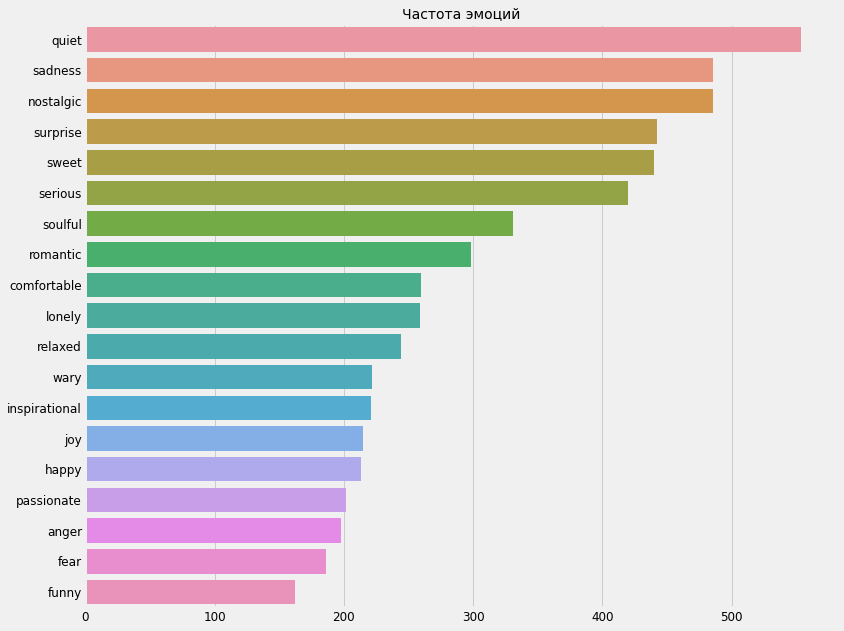

In [65]:
tracks = pd.read_csv(FILE_TRACKS)
tracks_emotions = tracks.dropna(subset=['emotions'])
print(f'Количество треков с метками эмоций: {len(tracks_emotions)}')

tracks_single_emotion = tracks_emotions[tracks_emotions.apply(lambda x: '|' not in x.emotions, axis=1)]
print(f'Количество треков с ровно одной эмоцией: {len(tracks_single_emotion)}')

label_freq = tracks_emotions.emotions.apply(lambda s: str(s).split('|')).explode().value_counts().sort_values(ascending=False)


style.use('fivethirtyeight')
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title('Частота эмоций', fontsize=14)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()